# "Principal Component Analysis"
> "Explain PCA using R and implementation from scratch in Python. Apply PCA to reduce dimensionality of MNIST Handwritten Digits, and Noise Reduction"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [notebook, R]
- image: images/vignette/pca.png
- hide: false
- search_exclude: true

# Structure
I have used R for some of the tasks and Python for the implementation of the PCA from scratch. If you are not familiar with R, you can still understand all of the material.

You can see the code by clicking on `show code` befor each code cell.

1. [Introduction to PCA](#Introduction-to-PCA)
2. [How PCA reduces dimensionlity](#How-PCA-reduces-dimensionality)
3. [Scree Plot](#Computing-PCA-and-Scree-Plot)
4. [Dimensionality reduction](#Dimensionality-reduction)
5. [PCA Code in python](#PCA-form-scratch-using-Python)
6. [Application - 1](#Application-1:-Data-Analysis)
7. [Application - 2](#Application-2:-Machine-Learning)
8. [Application - 3](#Application-3:-Denoising)
9. [Summary](#Summary)
10. [References](#References)

# Introduction to PCA
PCA is a **dimensionality reduction technique** used in Data Analysis and Machine Learning. 

Why we need PCA?<br/>
In Data Analysis, we can easily visualize a dataset with upto three features but for four or more features we can't envisage the data thus we use PCA to make it 3-D, 2-D or even 1-D **with minimum loss of inherent distribution of the data**.

In Machine Learning, a dataset with large number of features is computationally expensive and thus PCA can be used to reduce the number of features that do not account for much variance in the dataset.
> PCA requires working knowledge of eigenvalues and eigenvectors.

*Code in the below cell generates a synthetic dataset with **3 Features** and **50 Samples** generated from multivariate random distribution and without any covariance between the features.*

In [3]:
# collapse
options(warn=-1)
library(repr)
library(MASS)
library(ggplot2)
library(ggthemes)
library(ggrepel)
library('Cairo')
CairoWin()

nsamples <- 50
nfeatures <- 3
data <- matrix(nrow = nsamples, ncol = nfeatures)
colnames(data) <- paste("Feature", 1:nfeatures, sep = "")
rownames(data) <- paste("Sample", 1:nsamples, sep = "")

# Create
data[1:25,] = mvrnorm(n = 25, mu = c(3,3,3), Sigma = diag(3))
data[26:50,] = mvrnorm(n = 25, mu = c(-3,-3,-3), Sigma = diag(3))
head(data)

,Feature1,Feature2,Feature3
Sample1,2.569072,3.377418,3.9697152
Sample2,2.337470,2.033902,2.7146875
Sample3,3.512626,4.345042,0.1306245
Sample4,2.369885,3.613800,1.7934802
Sample5,2.428436,3.583442,3.3172790
Sample6,2.539318,2.958310,3.0142131


## Scatter Plot
> Feature3 is represented by the size of the point i.e larger the point => larger the Feature3

As it can be seen in the plot, **there are two clusters** in the data. So we would like to reduce dimensionality in such a way that it *preserves these clusters*.


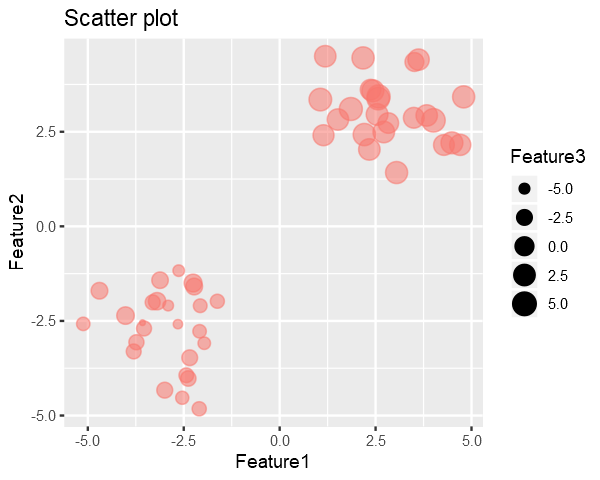

In [4]:
# collapse
p <- ggplot() +
geom_point(data=data.frame(data), 
           aes(x=Feature1, y=Feature2, size=Feature3, color="red", alpha=0.24)
) +
guides(color=F, alpha=F)  +
ggtitle("Scatter plot")
options(repr.plot.width = 5, repr.plot.height = 4)
p


# How PCA reduces dimensionality
Our goal is to remove the 3rd dimension(Feature3) from the generated data with minimal loss in the structure of the data.


1. A dataset with **N-Samples** and **M-Features** can be considered as a [N X M] matrix and we know that every matrix has a set of pairs of **Eigenvalues** and their corresponding **Eigenvectors** associated with it.
2. Eigenvecotrs are usual vectors and thus we know they refer to some direction.
3. Intuitively the Eigenvalues tells the amount of variance in data, in the direction of its corresponding Eigenvector.
4. Therefore the the Eigenvector with the highest Eigenvalue is the principal component of the data i.e. direction of maximum variance in the data.
5. The maximum variance Eigenvector will be the one for which the **Sum of Squared Distances (SSD) from points to the vector** is minimum.  
6. To find the Principle Component, we try to **find the best fitting line** for the data, similar to linear regression.
7. We might start with randomly drawing a line and then iteratively try to reduce the SSD to find best fitting line (In practice we use the **Closed-Form Solution** not iterative).<br/>
(contin.)

>*In the figure below, the blue lines represent the **distance b/w line and points**, and our goal in PCA is to minimize their squared sum.*

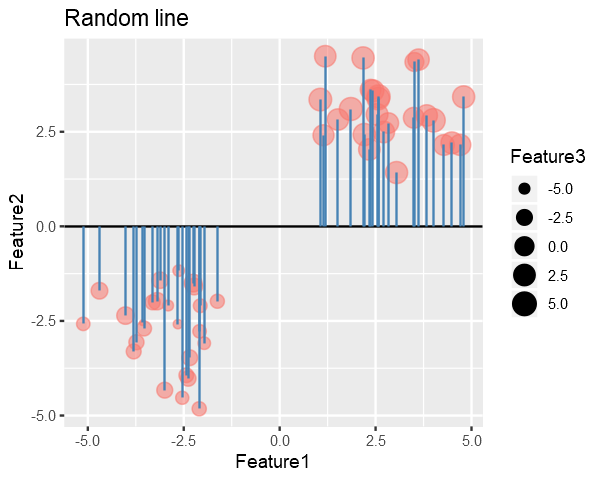

In [6]:
# collapse
slope <- 0

# Get the endpoints of points
perp.segment.coord <- function(x0, y0, a=0,b=1){
 #finds endpoint for a perpendicular segment from the point (x0,y0) to the line
 # defined by lm.mod as y=a+b*x
  x1 <- (x0+b*y0-a*b)/(1+b^2)
  y1 <- a + b*x1
  list(x0=x0, y0=y0, x1=x1, y1=y1)
}

ss<-perp.segment.coord(data[,1], data[,2], 0, slope)


p <- ggplot() +
geom_point(data=data.frame(data), 
           aes(x=Feature1, y=Feature2, size=Feature3, color="red", alpha=0.24)
) +
geom_abline(slope = slope, intercept = 0) +
guides(color=F, alpha=F)  +
ggtitle("Random line") +
geom_segment(data=as.data.frame(ss), aes(x = x0, y = y0, xend = x1, yend = y1), colour = "steelblue")
options(repr.plot.width = 5, repr.plot.height = 4)
p

Clearly we can do better than this, Line-1 is approximately the best fitting line. **Line-1(the best fit) is called the PC1 (Principle Component 1)** which accounts for the most variance.


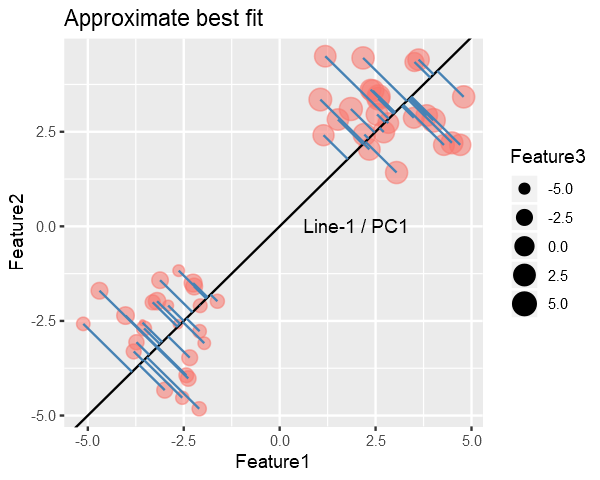

In [8]:
# collapse
slope <- 1
ss<-perp.segment.coord(data[,1], data[,2], 0, slope)

p <- ggplot() +
geom_point(data=data.frame(data), 
           aes(x=Feature1, y=Feature2, size=Feature3, color="red", alpha=0.24)
) +
geom_abline(slope = slope, intercept = 0) +
annotate("text", x= 2, y = 0 , label="Line-1 / PC1") +
guides(color=F, alpha=F)  +
ggtitle("Approximate best fit") +
geom_segment(data=as.data.frame(ss), aes(x = x0, y = y0, xend = x1, yend = y1), colour = "steelblue")
options(repr.plot.width = 5, repr.plot.height = 4)
p

(contin.) <br/>
8. Next step is to rotate the axes around origin to reorient the data and project data onto the Principle Component to get PC1.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

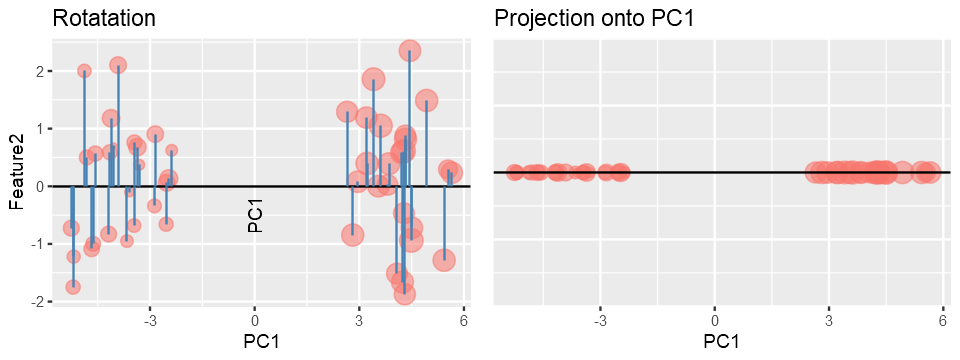

In [19]:
# collapse
theta <- 45
# x_new = xcosθ + ysinθ
# y_new = ycosθ – xsinθ
x = data[,1]
y = data[,2]
x_new = x*cos(theta) + y*sin(theta)
y_new = y*cos(theta) - x*sin(theta)
new_data = data
new_data[,1] = x_new
new_data[1:25,2] = y_new[1:25] + 1
new_data[26:50, 2] = y_new[26:50] - 1



slope <- 0
ss<-perp.segment.coord(new_data[,1], new_data[,2], 0, slope)

require(gridExtra)
p1 <- ggplot() +
geom_point(data=data.frame(new_data), 
           aes(x=Feature1, y=Feature2, size=Feature3, color="red", alpha=0.24)
) +
geom_abline(slope = slope, intercept = 0) +
annotate("text", x= 0, y = -.5 , label="PC1", angle=90) +
guides(color=F, alpha=F, size=F)  +
ggtitle("Rotatation") +
geom_segment(data=as.data.frame(ss), aes(x = x0, y = y0, xend = x1, yend = y1), colour = "steelblue")+
xlab("PC1")

p2 <- ggplot() +
geom_point(data=data.frame(new_data), 
           aes(x=Feature1, y=rep(0, 50), size=Feature3, color="red", alpha=0.24)
) +
geom_abline(slope = slope, intercept = 0) +
guides(color=F, alpha=F, size=F)  +
ggtitle("Projection onto PC1") +
xlab("PC1")+
theme(axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank())
grid.arrange(p1, p2, ncol=2)
options(repr.plot.width = 8, repr.plot.height = 3)

9. Once we have found the PC1, PC2 will be a line perpendicular to PC1 and PC3 will be perpendicular to PC2 and so on, because *for a symmetric matrix Eigenvectors are always orthogonal to each other and Eignevalues are always real*.
10. We get other PC's by simply projecting the data onto them.
11. Maximum number of PC's = minimum(features, samples)
12. The projected data will act as new Feature and we can discard the Features/PC's which accounts for less variance.

## Why PC's are always orthogonal (optional)
In practice, if the data has a shape [n x m] i.e. n-samples and m-features, PC's are calculated using either Scatter Matrix or Covariance Matrix for the data. Both of these are symmetric matrices with shape [m x m] (as covariance is calculate between features and the diagonal represents the variance) and therefore their Eigenvectors must be orthogonal.

> In a real world situation, we measure values of features on the original scales/axes i.e. Real Number line but this may not capture maximum essence of the data and therfore through PCA we essentially change our axes such that it now explains the data better than the original axes.


# Computing PCA and Scree Plot
I'll use **prcomp()** utility of R to calculate Principal Components of the data and then discard the component with less variance the reduce dimensionality.

In [20]:
# collapse
pca <- prcomp(data)
# prcomp returns x, stdev, rotation
# where x is the data transposed on PC's

**Scree Plot**: it shows the variance captured by each principal components.

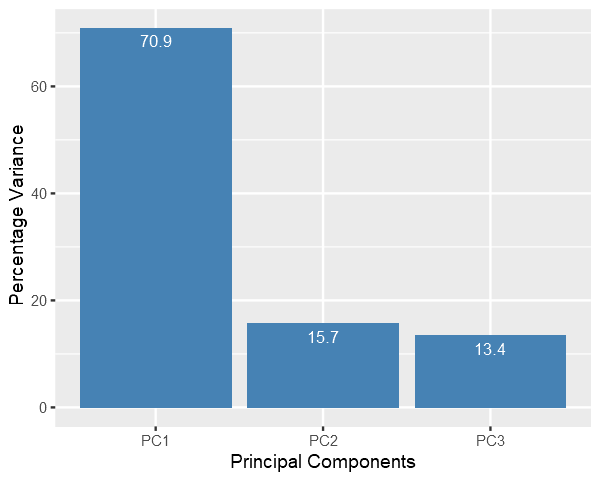

In [22]:
# collapse
pca.var = pca$sdev
# Percentage of variation each component accounts for
pca.var.per =  round(pca.var / sum(pca.var) * 100, 1)

ggplot(mapping = aes(x = paste("PC", 1:3, sep = ""), y = pca.var.per)) +
geom_bar(stat = "identity", fill='steelblue') +
xlab("Principal Components") +
ylab("Percentage Variance") +
geom_text(aes(label=pca.var.per), vjust=1.6, color="white", size=3.5)
options(repr.plot.width = 5, repr.plot.height = 4)

# Dimensionality Reduction
Finally we plot the data with reduced dimensions and it is evident from the figure that even if we discard the PC3, PC1 and PC2 still captures most of the distribution of the data.

Data is still divided into two clusters. 

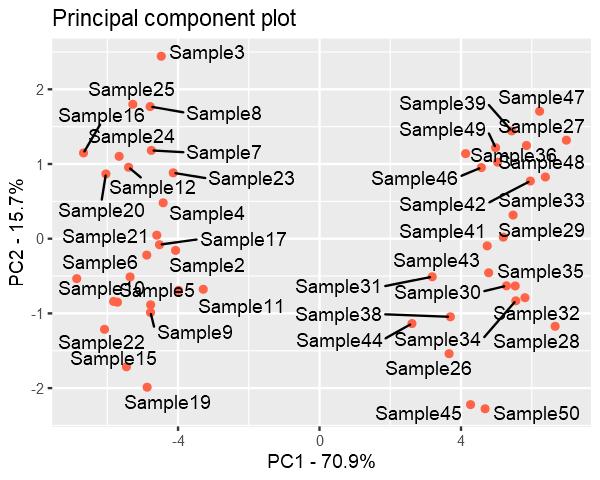

In [23]:
pca.data = data.frame(Sample=rownames(pca$x),
                      X = pca$x[,1],
                      Y = pca$x[,2])
ggplot(data=pca.data, aes(x = X, y = Y, label = Sample)) +
geom_point(color='tomato') +
geom_text_repel() + 
xlab(paste("PC1 - ", pca.var.per[1], "%", sep = "")) +
ylab(paste("PC2 - ", pca.var.per[2], "%", sep = "")) +
ggtitle("Principal component plot")

# PCA form scratch using Python
Overview of functions used:

1. `center_data()` - to scale the data such that each feature in the dataset has mean 0
2. `principal_component()` - returns the PC's (eigenvectors) of the data
3. `project_onto_PC()` - perform dimensionality reduction by projecting the data onto PC's
4. `plot_PC - used()` to visualize the resulting image after dimensionality reduction
5. `reconstruct_PC()` - reconstruct an image from PCA

Feel free to read the `docstrings` of functions to get an overview of their functionality.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


def project_onto_PC(X, pcs, n_components):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.

    Args:
        X - n x d Numpy array
        pcs - d x d Numpy array with each column as an eigenvector sorted in 
        decreasing order of their corresponding eigenvalues.
        n_components - (scalar) top principal components
    Returns:
        projected_data - n x n_components Numpy array with n samples and n_components features
    """
    # Step1: Center the data such that for each feature of a sample, mean = 0.
    # This step is often called scaling
    X_bar = center_data(X)

    # Step2: Projection onto the n_components principal components.
    n_pcs = pcs[:, :n_components]
    projected_data = X_bar @ n_pcs

    return projected_data



def center_data(X):
    """
    Returns a centered version of the data, where each feature now has mean = 0

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        n x d NumPy array X' where for each i = 1, ..., n and j = 1, ..., d:
        X'[i][j] = X[i][j] - means[j]
    """
    feature_means = X.mean(axis=0)
    return(X - feature_means)


def principal_components(X):
    """
    Returns the principal component vectors of the data, sorted in decreasing order
    of eigenvalue magnitude. This function first caluclates the covariance matrix
    and then finds its eigenvectors.

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        d x d NumPy array whose columns are the principal component directions sorted
        in descending order by the amount of variation each direction (these are
        equivalent to the d eigenvectors of the covariance matrix sorted in descending
        order of eigenvalues, so the first column corresponds to the eigenvector with
        the largest eigenvalue
    """
    centered_data = center_data(X)  # first center data
    scatter_matrix = centered_data.T @ centered_data
    eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
    # Re-order eigenvectors by eigenvalue magnitude:
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    return eigen_vectors


def plot_PC(X, pcs, labels):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function projects each sample in X onto the first two principal components
    and produces a scatterplot where points are marked with the digit depicted in
    the corresponding image.
    labels = a numpy array containing the digits corresponding to each image in X.
    """
    pc_data = project_onto_PC(X, pcs, n_components=2)
    text_labels = [str(z) for z in labels.tolist()]
    fig, ax = plt.subplots()
    ax.scatter(pc_data[:, 0], pc_data[:, 1], alpha=0, marker=".")
    for i, txt in enumerate(text_labels):
        ax.annotate(txt, (pc_data[i, 0], pc_data[i, 1]))
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()

def reconstruct_PC(x_pca, pcs, n_components, X):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function reconstructs a single image from its principal component
    representation, x_pca.
    X = the original data to which PCA was applied to get pcs.
    """
    feature_means = X - center_data(X)
    feature_means = feature_means[0, :]
    x_reconstructed = np.dot(
        x_pca, pcs[:, range(n_components)].T) + feature_means
    return x_reconstructed

# Application-1: Data Analysis
For the demonstration of capability of PCA, I'll use MNIST Dataset with 60000 images of `size - 28x28`. Each image consists of `28*28 = 784 features`, and using PCA **I'll reduce the number of features to only 2** so that we can visualize the dataset.

Even when we reduce the the data to such low dimensionality, the data will still contain some level of structure. That's the power of PCA.

Later on we'll see how do we know, how many Components are enough to properly describe the dataset, and how many are redundant.

Loaded mnist dataset with shape: (60000, 28, 28)
Original data shape: (28, 28)
Projected data shape: (2,)


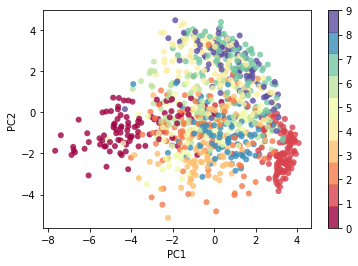

In [2]:
from keras.datasets import mnist
(data, labels), (_, _) = mnist.load_data()
# Scale the dataset
data = data.astype('float') / 255
print(f"Loaded mnist dataset with shape: {data.shape}")

n_components=2
flatten_data = data.reshape((60000, 28*28))
pcs = principal_components(flatten_data)
pca_data = project_onto_PC(flatten_data, pcs, n_components)
print(f"Original data shape: {data[0].shape}")
print(f"Projected data shape: {pca_data[0].shape}")

plt.scatter(pca_data[:1000, 0], pca_data[:1000, 1],
            c=labels[:1000], edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar();

Essentially, we have found the optimal stretch and rotation in 784-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

# Decide the Number of Components
For this task I'll utilize the `sklearn.decomposition.PCA` to get `explained_variance_ratio_`

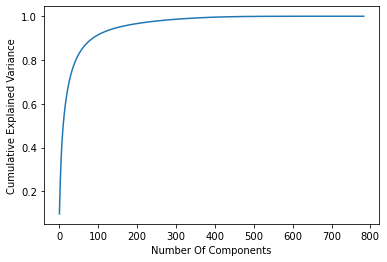

In [3]:
from sklearn.decomposition import PCA
pca = PCA().fit(flatten_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number Of Components')
plt.ylabel('Cumulative Explained Variance');

**As you can see, with using just 100 out of 784 components we can capture more than 90% of the variance in the data.**

# Application-2: Machine Learning
With a simple visualization I'll explain how reducing the dimensionality with PCA is useful.

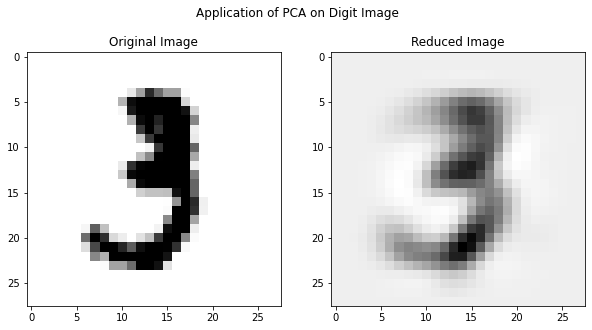

In [4]:
# collapse
n_components=18
pcs = principal_components(flatten_data)
pca_data = project_onto_PC(flatten_data, pcs, n_components)

reduced_image = reconstruct_PC(pca_data[10], pcs, n_components, flatten_data)
reduced_image = reduced_image.reshape((28, 28))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data[10], cmap='Greys')
ax[1].imshow(reduced_image, cmap='Greys')
ax[0].set_title("Original Image")
ax[1].set_title("Reduced Image")
fig.suptitle("Application of PCA on Digit Image");

The original image could be reconstructed if we use all of the PC's but here I used only 18 PC's and as you can see the reconstructed image still resembles the digit - three.

Reducing the dimensionality to sheer 18-Dimensions will still have fair amount of structure to be useful in a machine learning algorithm. This will save a lot of computational cost especially in case where dimensionality of data is very high. PCA often improves accuracy by eliminating the irrelevant features from the data.

# Application-3: Denoising

Origina Digits without any noise


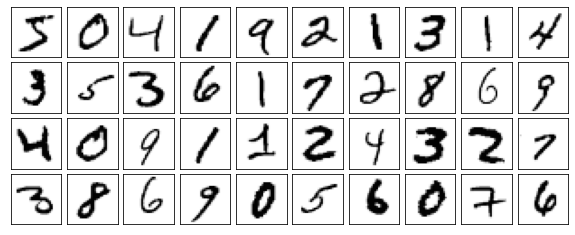

In [5]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='Greys')
print("Origina Digits without any noise")
plot_digits(flatten_data)

Noisy Images


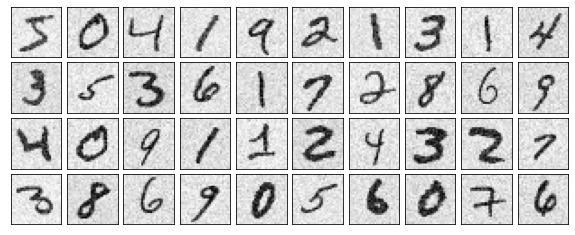

In [6]:
#Introduce some gaussian noise into the images.
np.random.seed(42)
noisy = np.random.normal(flatten_data, 0.1)
plot_digits(noisy)
print("Noisy Images")

In [7]:
pca = PCA(0.50).fit(noisy)
print(f"Components accountable for 50% variance: {pca.n_components_}")

Components accountable for 50% variance: 15


Here 50% of the variance amounts to 15 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits.

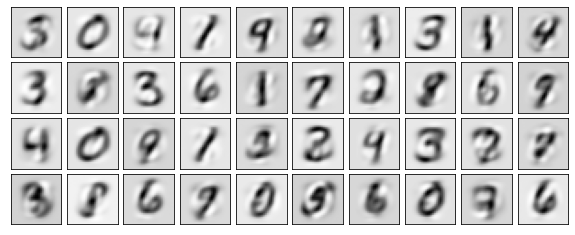

In [8]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

# Summary

PCA has several application apart from those mentioned above. It's even used in facial recognition. PCA plays useful role especially when we want to reduce dimensionality with low computational cost. PCA is very light algorithm and takes only few seconds to process very large datasets. Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines. Given any high-dimensional dataset, try to start with PCA in order to visualize the relationship between points (as we did with the digits) and to understand the intrinsic dimensionality (by plotting the explained variance ratio). Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

Scree-Plot and Cumulative Explained Variance prove to be very useful in every scenario.

# References



1. [PDF Resources from MIT OCW](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi63MufvIrxAhU_xDgGHYM-DCMQFjABegQIAxAD&url=https%3A%2F%2Focw.mit.edu%2Fcourses%2Fmathematics%2F18-650-statistics-for-applications-fall-2016%2Flecture-slides%2FMIT18_650F16_PCA.pdf&usg=AOvVaw280GLSgAN_PzDZw5v6FC8n)
2. [Video Lecture by Philippe Rigollet MIT](https://ocw.mit.edu/courses/mathematics/18-650-statistics-for-applications-fall-2016/lecture-videos/lecture-19-video/)
3. [Easy to understand video by StatQuest](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiigqWpvYrxAhWFYysKHbF3CdUQyCkwAHoECAUQAw&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DFgakZw6K1QQ%26vl%3Den&usg=AOvVaw1Uxn1Q77gN71tFBwdJxhGR)
5. [Intuitive explanation of Eigenvalues and Eigenvectors by 3Blue1Brown](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi6lYHOvYrxAhXKXCsKHcz1BgMQwqsBMAB6BAgIEAE&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DPFDu9oVAE-g%26vl%3Den&usg=AOvVaw2X0kBufXJMrtHaWA0zlG3b)
6. [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
7. [prcomp()](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/prcomp)